# *Next Dish* - finding your next vegan meal

## I. Introduction

About four months ago, I made a significant personal dietary change - by 'going vegan.' Though I had fully expected the difficulties that would come with my regular grocery shopping, I was honestly surprised to discover how difficult it was to source meals on the go.

Perhaps the best resources that currently exist are apps like Yelp and Foursquare. However, a quick search for vegan items on either of these apps surfaces, at best, a few restaurants that may or may not actually serve vegan dishes. Why? Reviews or tips by disgruntled vegan users may be surfaced - not relevant venues. Other times, you are forced to look through menu after menu searching for items that might fit the dietary requirements. Worse yet, you are only able to search through nearby venues, even if you were willing to take public transportation a few stops to find suitable options. These issues stem principally from the approach that existing products take to sourcing meals, namely by locating relevant venues. But as might be obvious, one can often locate vegan dishes at omnivorous venues, not just at exclusively vegan ones. So I set out to instead prioritize what has thusly been overlooked: the dishes themselves. For my project, I hope to predict whether or not a particular menu item is vegan. By building a relatively robust predictive model, I could then see a few direct to consumer business opportunities. For example, I could create a Foursquare-esque competitor that would surface strictly menu items predicted to be vegan. To improve the quality of results, I would suggest adding user inputs, such as a voting mechanism, as a check to corroborate the predicted options surfaced via my model. Alternatively, I would hope to leverage my work to create a simple widget that would surface likely food groups (for example, if the item has dairy/eggs) when provided a user inputted food item. I could also give a prediction regarding whether the item was vegan, so it could have utility for quickly researching a novel item found at a particular venue.

## II. Executive Summary

### Problem Statement

The crux of the issue for any hungry vegan on the move is not necessarily which venue to frequent, as that is a luxury reserved for the omnivorous. Rather, it is even more fundamental: can I find a dish that I will actually be able to order? In looking to address this issue, vegans often cannot discriminate venues but need to evaluate their options on a dish-to-dish basis, across a variety of venues and menus. For that reason, I chose to first investigate where I might be able to find complete menu information for particular venues. Upon satisfying that requisite, I could move on to build a model that would automatically pick out which items were likely to be vegan, or not.

### Defining the end goal

A vegan diet restricts an individual to eat only within the realm of goods that can be considered not to have been produced with or by any animal products. As such, my methodology for defining particular food items was to first batch them into tangible food groups, which could then be referenced to better understand how machine learning techniques are predicting particular items to be vegan, and others not to be.

## III. Data Collection

Knowing that Yelp had a reasonably comprehensive open API, I first pondered the possibility of collecting menu information from them. Unfortunately, I quickly realized that the amount of granular, item-by-item menu information that Yelp had was minimal - in turn making my project a virtual no-go.

I subsequently turned to Foursquare, which to my surprise had indexed an incredible number of menus across the venues that they surface via organic search. My curiosity had been peaked. How was it possible that Foursquare had such reliable, well-organized data on their platform around menus, when Yelp did not? After some additional research, I learned that Foursquare had a partnership with a significant third-party reseller of small-business information, named Locu (https://locu.com/). As it turned out, Locu itself had an open API that was relatively accessible years ago, but it had been shut off to the public after it was acquired by GoDaddy. Even after some digging, I was sadly unable to come up with even a sample of the Locu data. This left me with one remaining option, which was to look at the Foursquare API.

## A. Approach

Having concluded that Foursquare would be the best source for gathering complete menus, I began experimenting with a couple different endpoints to their API. Unfortunately, I discovered early on that a) I would be capped from collecting as many menu items from unique menus as I needed (at least several thousand items in toto) and b) I wouldn't be able to collect menus from as many venues as I had originally hoped. On the bright side, I did notice that it would be possible to collect a significant number (thousands) of urls identifying unique venue menus. So even though I wouldn't be able to easily collect my data through a handful of API calls, it *would* be possible to scrape the Foursquare menu urls themselves...

## B. Getting the urls

To get the menu urls, I had two Endpoints available to me entailing differing challenges: the 'Search' Endpoint would allow me to gather information on an entire region, though restricted by geographical bounds; the 'Explore' Endpoint would only surface venues close to the inputted geographic parameters, and only the ones that ranked best (the top 50, or so).

To capture as much data as possible in SF proper, I decided to loop through latitude and longitude coordinates in increments of approximately a half mile.

In [26]:
# pip install scrapy
# pip install --upgrade zope2

from collections import Counter
import foursquare
from ipywidgets import widgets
from IPython.display import display
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
from operator import itemgetter
import pandas as pd
import pickle
import random
import requests
from scrapy import Selector
from scrapy.http import HtmlResponse
import seaborn as sns
from sqlalchemy import create_engine
import sqlite3
import textacy
import textacy.data
import time
import unicodedata

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
#Let's define a geo dictionary whose bounds encompass all of SF, and another 4 miles south as well (so ~7mi x 11mi)
ne = {'ne_lat': -122.3550796509, 'ne_long': 37.8127675576}
sw = {'sw_lat': -122.5164413452, 'sw_long': 37.7078622611}

# east/west
lat_bounds = [ne['ne_lat'], sw['sw_lat']]
print lat_bounds[0]
# north/south
lon_bounds = [ne['ne_long'], sw['sw_long']]
print lon_bounds

#increment ~ half a mile (in latitude/longitude), is 0.007
increment = 0.007

# The gridding below moves North, starting from the bottom SW corner boundary, and then moves east half a mile,
# and repeats the process until stopping at the NE corner boundary.
grid_pairs = []
for lat in np.arange(lat_bounds[1], lat_bounds[0], increment):
    for lon in np.arange(lon_bounds[1], lon_bounds[0], increment):
        grid_pairs.append([lat, lon])
        
print len(grid_pairs)

While I was initially more bullish on using these coordinate pairs with the Search endpoint, I later realized that in fact the Explore endpoint was returning significantly greater numbers of relevant venues (approximately 10x more, in fact).

## C. API Calls

Armed with appropriate coordinate pairs, I was able to write code that would make API calls while looping through specific areas of SF; by breaking up all of SF into smaller squares I was able to return a greater number of unique venues.

If I were to use the Search Endpoint, I would have had to automate the creation of menu url's off the back of API calls, because that endpoint does not provide them directly. But, the Explore Endpoint allowed me to directly grab the menu url's, which made the process much easier (I have labeled them below as 'explored_venue_ids').

In [ ]:
# Here, I work with the Explore Endpoint

# This will pull the venue names and url's (labeled as 'explored_venue_ids') that correspond to the geographical
# areas I paired off in the previous step with grid_pairs. These are the  urls that I then intend to scrape in
# subsequent steps.

unique_venues_from_explore = []
unique_venue_names_from_explore = []
start_time = time.time()
counter = 0
for x, y in grid_pairs:
    for offset in range(50, 251, 50):
        try:
            # Radius is radius in meters around given 'll'; 800 meters
            # is approx 0.5 miles (but I may adjust the radius going forward)
        
            explore = client.venues.explore(params={'ll': '%.2f, %.2f' % (y, x), 'llAcc':'100.0','radius': '2000',
                                               'section': 'food','limit':'50','offset':''+str(offset)+'',
                                                    'sortByDistance':'1'})
            explored_venue_ids = []
            explored_venue_names = []

            for i in range(len(explore['groups'][0]['items'])):
                try:
                    pulled_id = explore['groups'][0]['items'][i]['venue']['menu']['url']
                    explored_venue_ids.append(pulled_id)
                    pulled_name = explore['groups'][0]['items'][i]['venue']['name']
                    explored_venue_names.append(pulled_name)
                except:
                    pass
            for next_id, next_name in zip(explored_venue_ids, explored_venue_names):
                if 'foursquare.com' in str(next_id):
                    unique_venues_from_explore.append(next_id)
                    unique_venue_names_from_explore.append(next_name)
            counter += 1
            print("--- %s seconds ---" % (time.time() - start_time)), "loop number:", counter
        except:
            pass

## D. Scraping

Given that I now had a relatively comprehensive list of about 1000 venues in SF that had made menu information available (it is estimated that about 5000-8000 venues exist in total), I was ready to start scraping. So, I created a function that would take as a parameter one url at a time. I identified about ten (10) fields of interest that I wanted to account for with each venue, and used Scrapy to assist with reading the HTML into my Python notebook.

In [ ]:
# Now that I have plenty of urls, let's plug them into a scraper so I can populate my df. Here are the headers
# I'm looking to get as well...

column_headers = ['venue_name', 'venue_desc_list', 'vegan_venue_check', 'venue_menu_url', 'venue_rated',
                  'meta_menu_n', 'depth_menus_n', 'menu_item_name', 'menu_item_price', 'menu_item_desc']

df_ready_rows = []
def parse_url(url, data=False):

    response               =  requests.get(url)
    
    #Steps:
    #1) get the unicode objects
    #2) change objects from unicode to string
    
    venue_name_uni         = Selector(text=response.text).xpath('//h1[@class="venueName"]/text()').extract()
    venue_name             = unicodedata.normalize('NFKD', venue_name_uni[0]).encode('ascii','ignore')
    
    # I also need to do an iteration to capture the multiple descriptors.
    # I'll store the descriptors in a list to capture the entire description:
    venue_desc_uni         =  Selector(text=response.text).xpath('//span[@class="unlinkedCategory"]/\
    text()').extract()
    venue_desc_list        = []
    vegan_venue_check      = [] # I'll also do a quick check to see up front if we have a vegan menu on our hands
    for venue_desc_phrase in range(len(venue_desc_uni)):
        venue_desc_n       = unicodedata.normalize('NFKD', venue_desc_uni[venue_desc_phrase]).encode('ascii',
                                                                                                  'ignore')
        venue_desc_list.append(venue_desc_n)

    # Here I am going to manually label all my menu items which correspond to restaurants that Foursquare already
    # recognizes as vegan. They're specific label for a vegan venue is 'Vegetarian / Vegan Restaurant' - this may
    # be misleading and incorrectly read as vegetarian or vegan, with it in fact means that it is vegetarian, but
    # more specifically, vegan.
    
    flat_desc = ' '.join(venue_desc_list)
    if 'vegetarian / vegan restaurant' in flat_desc.lower():
        vegan_venue_check  = 'vegan'
    else:
        vegan_venue_check  = 'not_vegan'

    # The url too, right?
    venue_menu_url         = url

    # Grabbing the venue rating, just a note: venueScore positive/neutral/negative, but I'm only getting the
    # rating number, on a scale 1-10
    venueScore_options     = ['positive','neutral','negative']
    venue_rated = 'placeholder'
    for vs_option in venueScore_options:
        try:
            venue_rating_uni        = Selector(text=response.text).xpath('//div[@class="venueRateBlock  "]/\
    span[@class="venueScore '+vs_option+'"]/span/text()').extract()
            venue_rating            = unicodedata.normalize('NFKD', venue_rating_uni[0]).encode('ascii','ignore')
            venue_rated             = float(venue_rating)
        except:
            pass
        
    # Even if there is no rating, I'd still like to keep track of that...
    if venue_rated == 'placeholder':
        venue_rated = 'rating_not_available'
        
    #And I'll transform the list back into a string...
#     venue_rated = venue_rated[0]
    
    #NOTE: do i also need to account for when menus don't have titles? because in that case meta_menu_list
    #could/would
    #return null. if so, perhaps just do a 'try excepct:pass' function if it can't find titles, but could it still
    #grab the menu items? maybe i should just put in a "null title" for the meta_menu_n to overcome this
    #I no longer think this is an issue, but maybe something to put in the appendix for later?
    
    meta_menu_list      =  Selector(text=response.text).xpath('//h2[@class="categoryName"]/text()').extract()
        
    for meta_menu_item in range(len(meta_menu_list)):
        
        meta_menu_n         = unicodedata.normalize('NFKD', meta_menu_list[meta_menu_item]).encode('ascii',
                                                                                                   'ignore')
        
#         print "meta menu title %d:" %(meta_menu_item+1), meta_menu_n, "# of meta menus:", len(meta_menu_list)
        
        depth_menus_n_uni = Selector(text=response.text).xpath('//div[@class="menu"]['+str(meta_menu_item+1)+']/\
        div[@class="menuItems"]/div[@class="section"]/div[@class="sectionHeader"]/\
        div[@class="sectionName"]/text()').extract()
        
        for meta_depth_nn in range(len(depth_menus_n_uni)):
            
            depth_menus_n     = unicodedata.normalize('NFKD', depth_menus_n_uni[meta_depth_nn]
                                                     ).encode('ascii','ignore')

            #get the name of the depth menu, and record it's location as 'n_level'
            n_level = meta_depth_nn+1
#             print "depth menu title %d:" %(n_level), depth_menus_n
            
            #let's grab the entire depth menu:
            depth_menu_id_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
            ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]['+str(n_level)+']/\
            div[@class="sectionHeader"]/div[@class="sectionName"]/text()').extract()
            depth_menu_id     = unicodedata.normalize('NFKD', depth_menu_id_uni[0]
                                                     ).encode('ascii','ignore')
            depth_menu_id = len(depth_menu_id_uni)
#             print "#id of depth menu:", depth_menu_id
            
            #loop throught the left and right side of each container:
            left_or_right_list = ['left','right']
            
            for left_or_right in left_or_right_list:
    
                #need the length of the [left/right] container, to iterate through:
                container_len_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
                ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]['+str(n_level)+']/div\
                [@class="entryContainer"]/div[@class="'+left_or_right+'Column"]/\
                div[@class="entry"]/node()[1]//text()').extract()
#                 print "left_check:", left_or_right, "contain len:", len(container_len_uni)
            
                for section_n in range(len(container_len_uni)):                    
                    
                    #now we can get the name of that menu item...
                    menu_item_name_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
                    ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]\
                    ['+str(n_level)+']/div\
                    [@class="entryContainer"]/div[@class="'+left_or_right+'Column"]/div[@class="entry"]\
                    ['+str(section_n+1)+']/node()[1]//text()').extract()
                    menu_item_name     = unicodedata.normalize('NFKD', menu_item_name_uni[0]
                                                                    ).encode('ascii','ignore')
#                     print "menu_item_name:", menu_item_name
                    
                    #and then we can get the price (if there is one...)
                    try:
                        menu_item_price_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
                    ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]\
                    ['+str(n_level)+']/div\
                    [@class="entryContainer"]/div[@class="'+left_or_right+'Column"]/div[@class="entry"]\
                    ['+str(section_n+1)+']/node()[2]//text()').extract()
                        menu_item_price     = unicodedata.normalize('NFKD', menu_item_price_uni[0]
                                                                    ).encode('ascii','ignore')
                        menu_item_price = float(menu_item_price)
#                         print "menu_item_price:", menu_item_price
                    except:
#                         print "menu_item_price:", "price_not_available"
                        menu_item_price = 'price_not_available'
                    
                    #and finally the description (if there is one...)
                    try:
                        menu_item_desc_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
                    ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]\
                    ['+str(n_level)+']/div\
                    [@class="entryContainer"]/div[@class="'+left_or_right+'Column"]/div[@class="entry"]\
                    ['+str(section_n+1)+']/node()[3]//text()').extract()
                        menu_item_desc     = unicodedata.normalize('NFKD', menu_item_desc_uni[0]
                                                                    ).encode('ascii','ignore')
#                         print "menu_item_desc:", menu_item_desc
                    except:
#                         print "menu_item_desc:", "desc_not_available"
                        menu_item_desc = 'desc_not_available'

                    # Finally, I'll append my results so that when I wrap up the fuction, I can finish with
                    # a prepared set of info, dataframe ready.
                    df_ready_rows.append([venue_name,
                                          venue_desc_list,
                                          vegan_venue_check,
                                          venue_menu_url,
                                          venue_rated,
                                          meta_menu_n,
                                          depth_menus_n,
                                          menu_item_name,
                                          menu_item_price,
                                          menu_item_desc])
    return df_ready_rows

After some tests, I felt confident enough to run my scraper at the next level of scale, and fed in all my collected urls. This would result in a single dataframe with all my menu information cleanly filtered and organized. So the majority of cleaning that would have been done was fortunately handled by the scraper.

In [ ]:
start_time = time.time()
countered = 0
for menu_url in unique_venues_from_explore:
    try:
        parse_url(menu_url)
    except:
        pass
    countered += 1
    print("--- %s seconds ---" % (time.time() - start_time)), "loop number:", countered
# Takes about 4 mins for 30 url's

# IV. Exploratory Data Analysis

Seeing as I was working almost exclusively with natural language data, I decided that a useful approach to EDA would be one that was fairly agnostic to the dataset, and treated each field as potentially merting further investigation. All the while, I had in the back of my mind that the most useful field/feature would likely be the name of the menu item itself.

*Note: Data labeled as 'omni' (omnivorous) includes all food types. The vegan subset only reflects items that were labeled by Locu/Foursquare as being definitively vegan. Therefore, there may be vegan items in the omni pool of data that are not recognized as vegan, despite being so.*

    *Number of items represented in data set: 90,047
    *Number of items pre-tagged as being vegan: 1,861

In [11]:
food = pd.read_pickle('../../../../Accounts/Electo:Computad/\
MacBook Pro/Software/Github/Old_repos/DSI-SF-4-anotherguitar/projects/Capstone Stuff/explore_endpoint_df.pkl')
vegan = food[food.vegan_venue_check == 'vegan']

## A. Item Descriptions

Turns out that the plot of the top item descriptions is not terribly descriptive. We see a set of venues that use the same descriptions for a variety of different dishes - for example, the 'serves 50-75' (etc.) is from a single bakery.

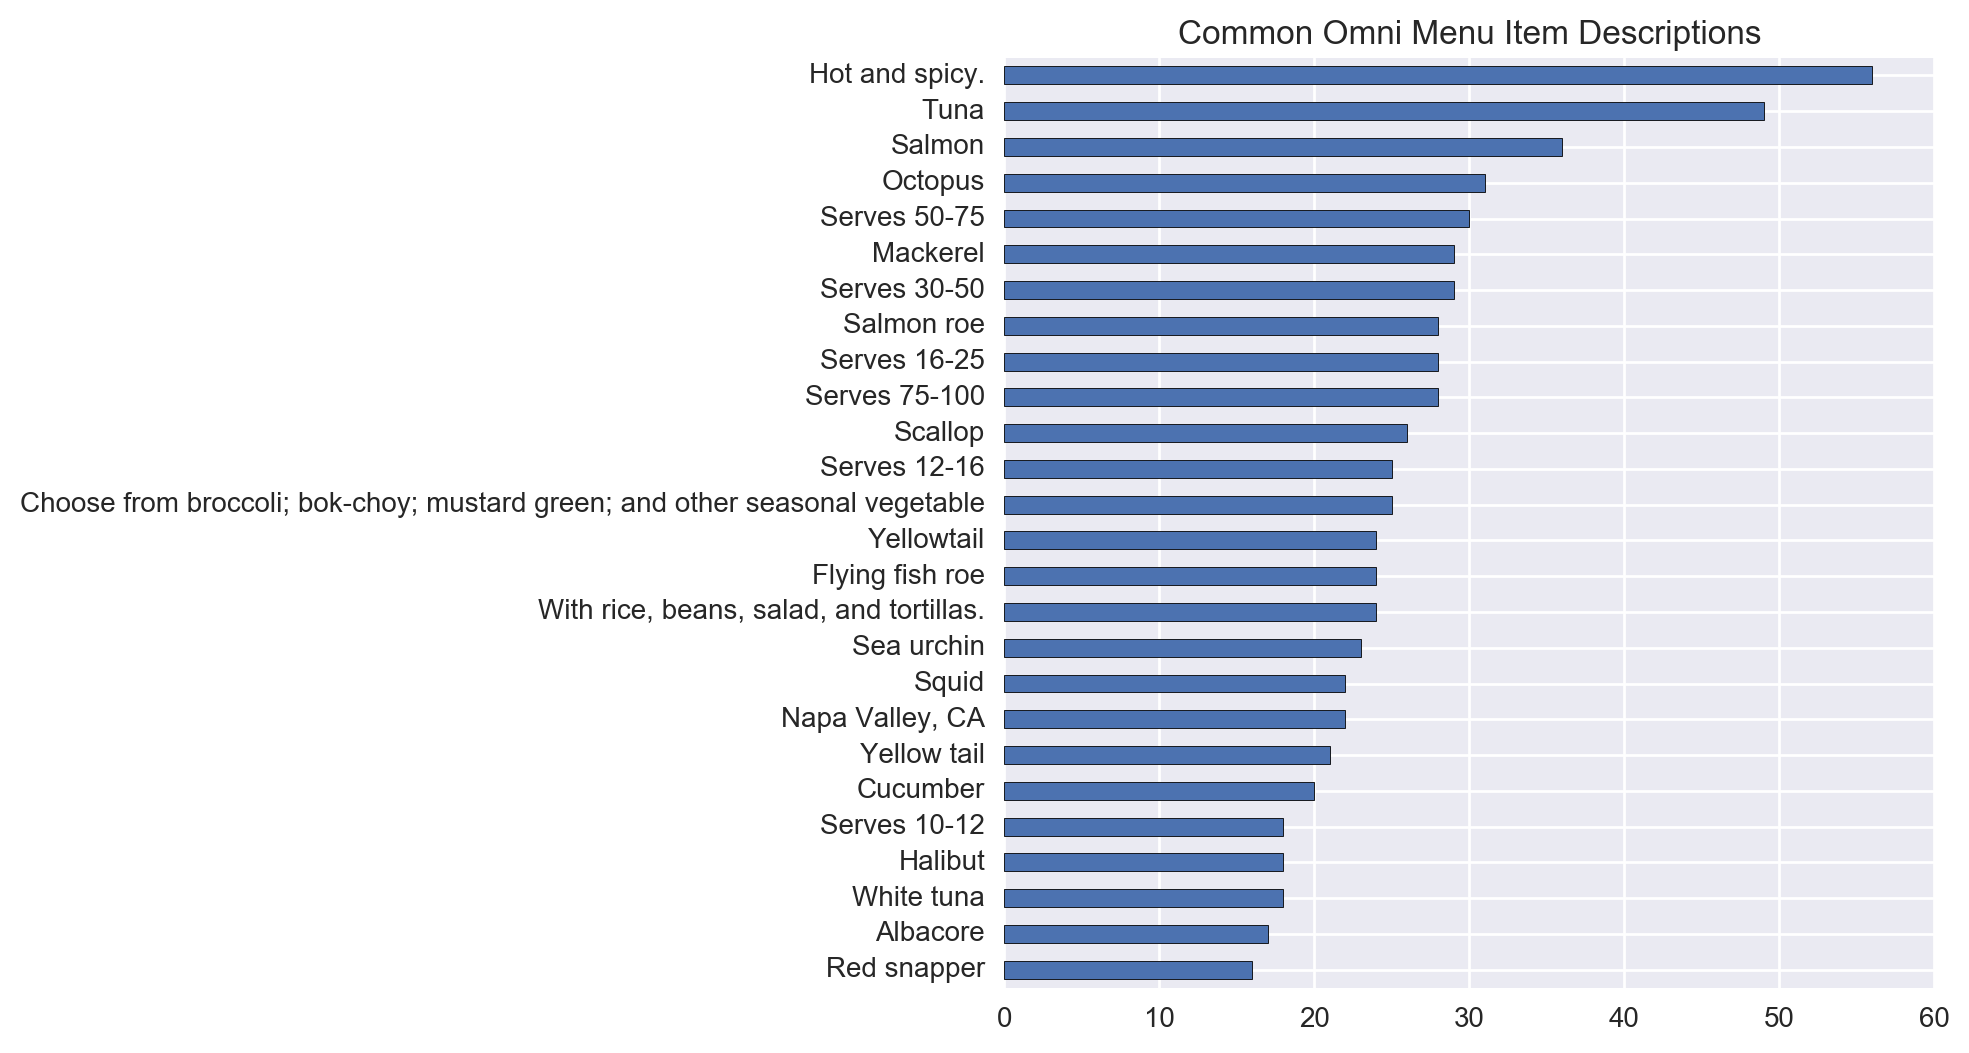

In [12]:
# Let's plot the most common item descriptions
desc_count = food[food.menu_item_desc != 'desc_not_available']
desc_count = desc_count[desc_count.groupby('menu_item_desc').menu_item_desc.transform(len) > 15]

plt.figure(figsize=(6,6))
desc_count['menu_item_desc'].value_counts().sort_values().plot(kind='barh')
plt.title('Common Omni Menu Item Descriptions')

If we contrast the above plot with just the vegan subset, we find that the most common menu item descriptions in vegan venues are distributed relatively evenly. However, it is important to mention that a few venues in each set of data are overrepresented. This comes as a result of those venues using the same descriptions for a variety of items on their respecitve menus.

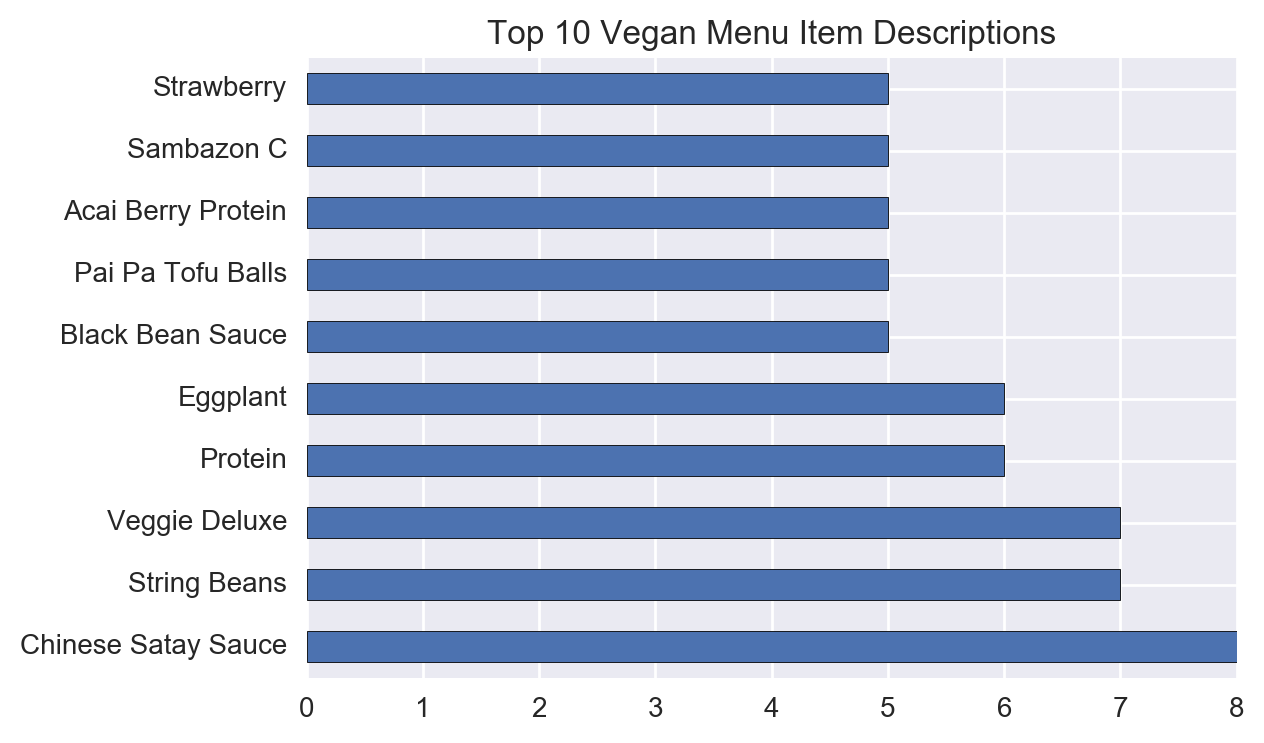

In [13]:
vegan_desc = vegan[vegan.menu_item_desc != 'desc_not_available']
vegan_desc = vegan_desc[vegan_desc.groupby('menu_item_desc').menu_item_desc.transform(len) > 0]
vegan_tops = vegan_desc.menu_item_name.value_counts()
vegan_tops = vegan_tops[:10]
vegan_tops.plot(kind='barh')

plt.title('Top %s Vegan Menu Item Descriptions' %len(vegan_tops))

## B. Item Names

Most commonly, we observe beverages and condiments as having relatively uniform naming conventions. Potentially notable standouts, though, include French Fries, Chicken Salad, Chicken Teriyaki, Salmon, Greek Salad, Green Salad and Tiramisu. This may reflect base traits that exist across a variety of menus, and furthermore, the palate of the San Franciscan who goes out to eat - in other words, the market is supplying these products at a higher rate, possibly because of pre-existing local preferences.

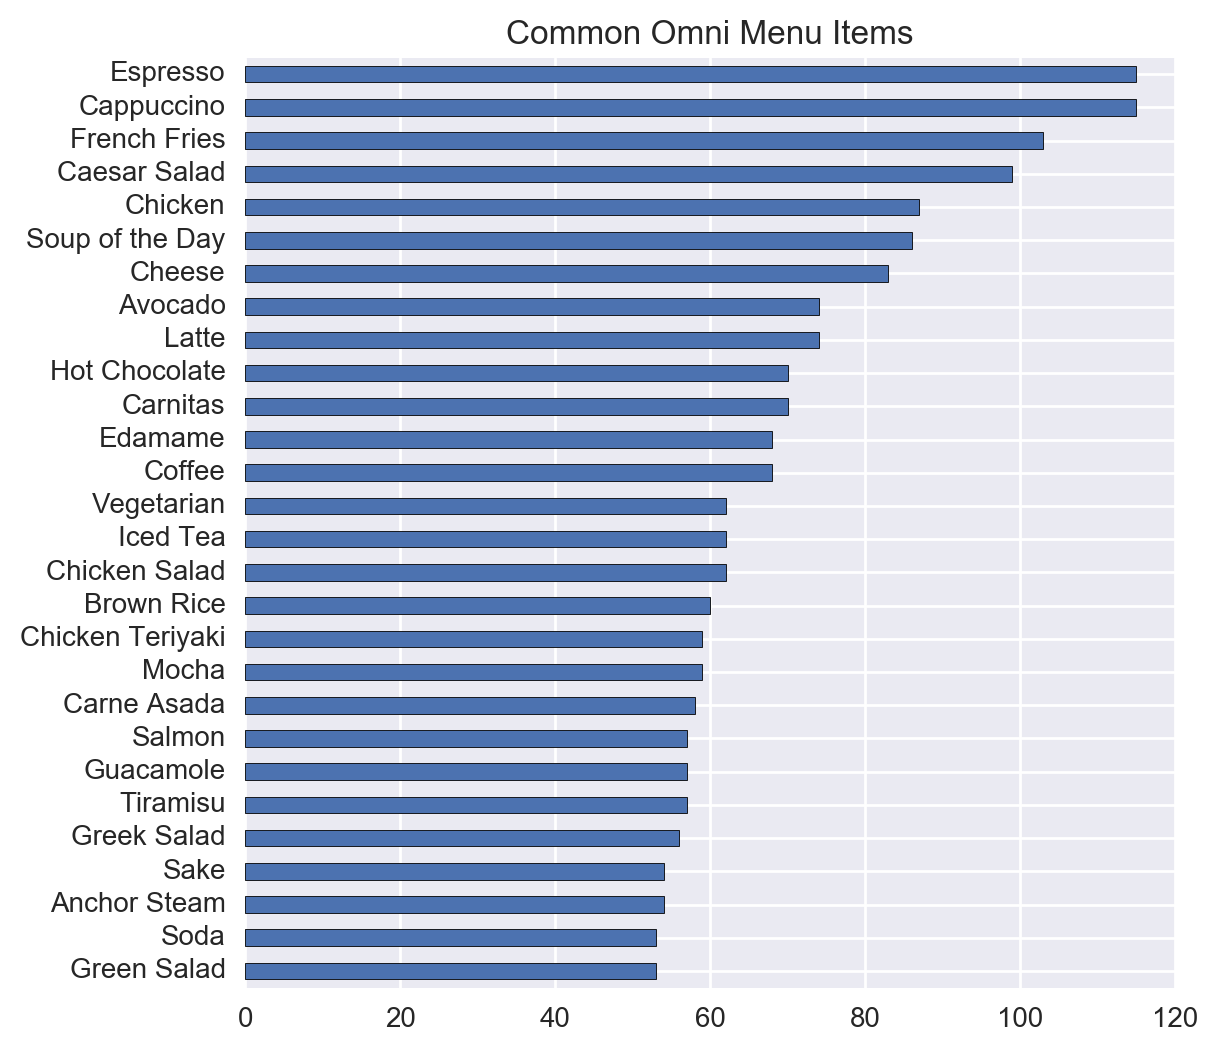

In [14]:
# Let's try the most common items
item_count = food[food.groupby('menu_item_name').menu_item_name.transform(len) > 50]
item_count.menu_item_name.value_counts()

plt.figure(figsize=(6,6))
item_count['menu_item_name'].value_counts().sort_values().plot(kind='barh')
plt.title('Common Omni Menu Items')

In [15]:
# Out of curiosity, I'm going looking at the various descriptions under French Fries
food[food.menu_item_name == 'French Fries'].menu_item_desc.value_counts().head()

# Turns out that one French Fries dish is a whole lot like any other French Fries dish. Who would have thought?

desc_not_available                         80
Smoky ketchup, sweet-onion aioli            2
Smoky tomato ketchup, sweet-onion aioli     2
Anchovy Ketchup                             2
With aioli                                  2
Name: menu_item_desc, dtype: int64

Below I repeated the same analysis, but for the vegan subset. This basically indicates that unlike omni venues, vegan venues have very few menu items that can be found at different venues i.e. vegan venues tend to have unique menu items. This finding is similar to that which was given for the vegan item descriptions.

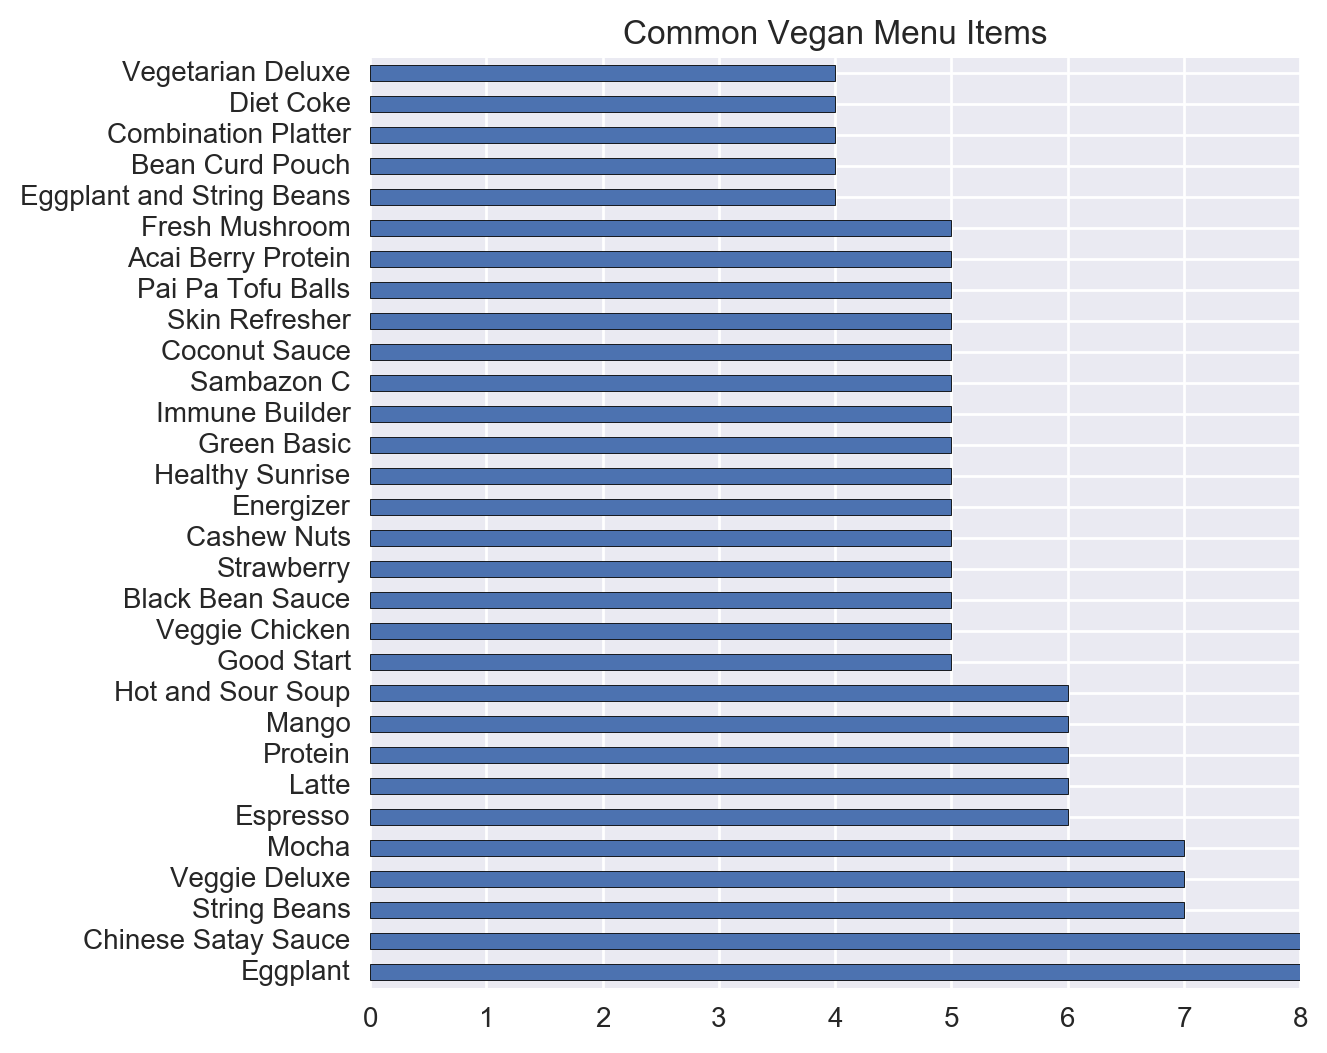

In [16]:
# Let's try the most common vegan items
item_count = vegan[vegan.groupby('menu_item_name').menu_item_name.transform(len) > 0]
vegan_tops = item_count.menu_item_name.value_counts()

plt.figure(figsize=(6,6))
vegan_tops[:30].plot(kind='barh')
plt.title('Common Vegan Menu Items')

## C. Item Pricing

I followed up by looking at the specific price points that venues were using. This means that though $12 was the most common price point, $11.95 shows up separately as another common price point. For that reason, I made an easy-to-use widget below that allows a user to input a range of prices, and learn
    - 1) how many items in my dataset fit in that range, inclusively
    - 2) an approximate percentage of how many items fit in that range, inclusively
    - 3) an approximate percentage of how many unique items fit in that range, inclusively
It is also notable how while there is a slight skew for the exact price point data, on whole, pricing is distributed across a wide range.

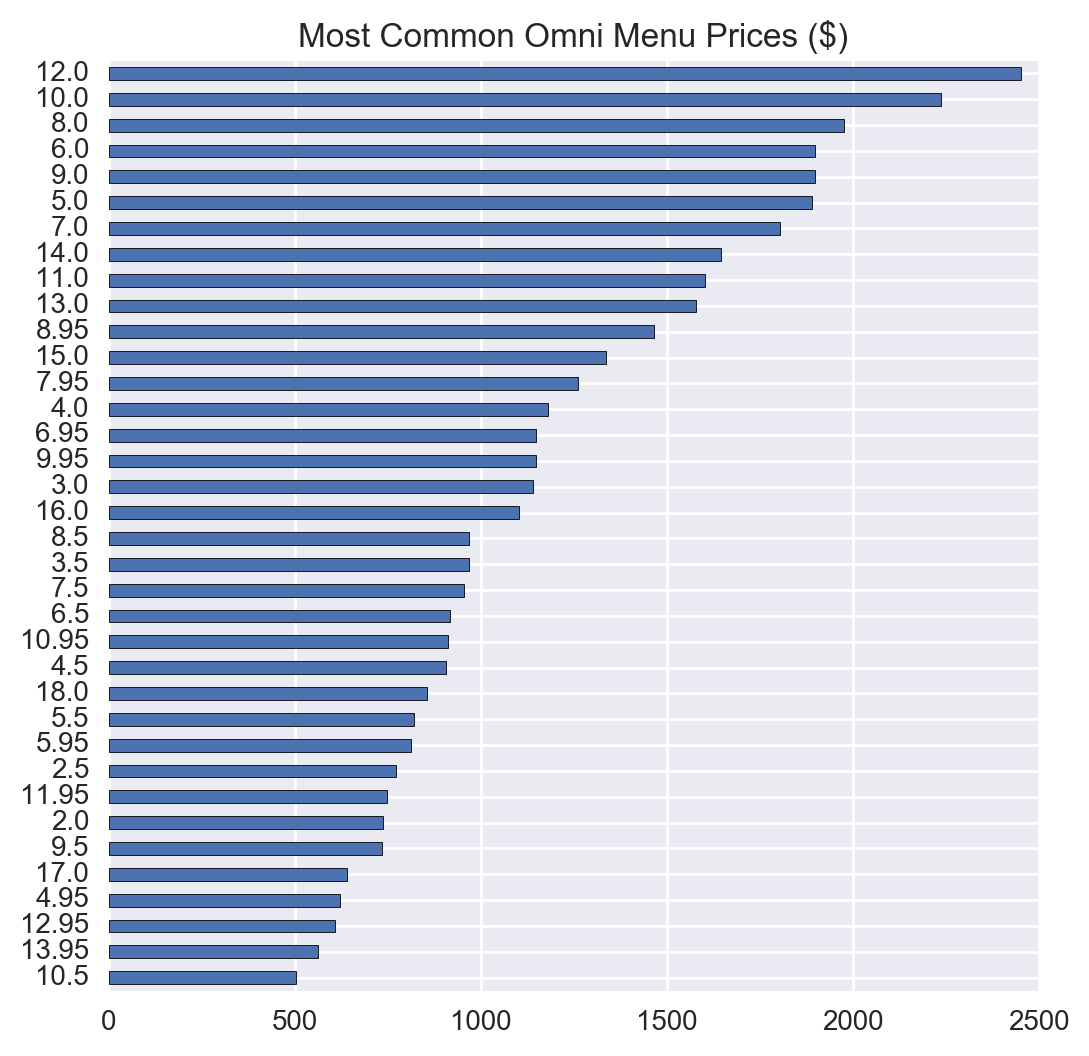

In [17]:
# Let's try the most common item prices
item_price = food[food.groupby('menu_item_price').menu_item_price.transform(len) > 500]
item_price = item_price[item_price.menu_item_price != 'price_not_available']
item_price.menu_item_price.value_counts()

plt.figure(figsize=(6,6))
item_price['menu_item_price'].value_counts().sort_values().plot(kind='barh')
plt.title('Most Common Omni Menu Prices ($)')

In [101]:
has_price = food[food.menu_item_price != 'price_not_available']
# lower_bound = 11.49
# upper_bound = 12.49
def price_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    print "Items in the $%.2f-$%.2f range:" % (lower_bound, upper_bound), common_omni.shape[0]
def percentage_in_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    percents = float(len(common_omni.menu_item_name))/ len(has_price.menu_item_name) * 100.
    print "Approx percentage of items in $%.2f-$%.2f range:" % (lower_bound, upper_bound), round(percents)
def unique_percentage_in_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    print "Approx percentage of unique items in the $%.2f-$%.2f range:" %(lower_bound, upper_bound), \
round(float(len(common_omni.menu_item_name.unique()))/len(has_price.menu_item_name.unique())*100)

In [103]:
lower_bound = widgets.Text(description="Lower Bound:", placeholder="Enter a low price!")
upper_bound = widgets.Text(description="Higher Bound:", placeholder="Enter a high price!")

my_button = widgets.Button(description="This best be good...")

def on_submit(ui):

    item_count = price_range(float(lower_bound.value), float(higher_bound.value))
    percents = percentage_in_range(float(lower_bound.value), float(upper_bound.value))
    percent_counts = unique_percentage_in_range(float(lower_bound.value), float(upper_bound.value))
    return item_count, percents, percent_counts

my_button.on_click(on_submit)

display(lower_bound)
display(upper_bound)
display(my_button)

A histogram of the data somewhat confirms the sense that menu price points are distributed across a range. But, we can also surface the approximate median, which is just under the $10$ mark. The mean would be out above $30$, indicating a strong right skew.

*Note: I have only included that prices with at least 300 data points in the graph. However, the median is based on all the available pricing data.*

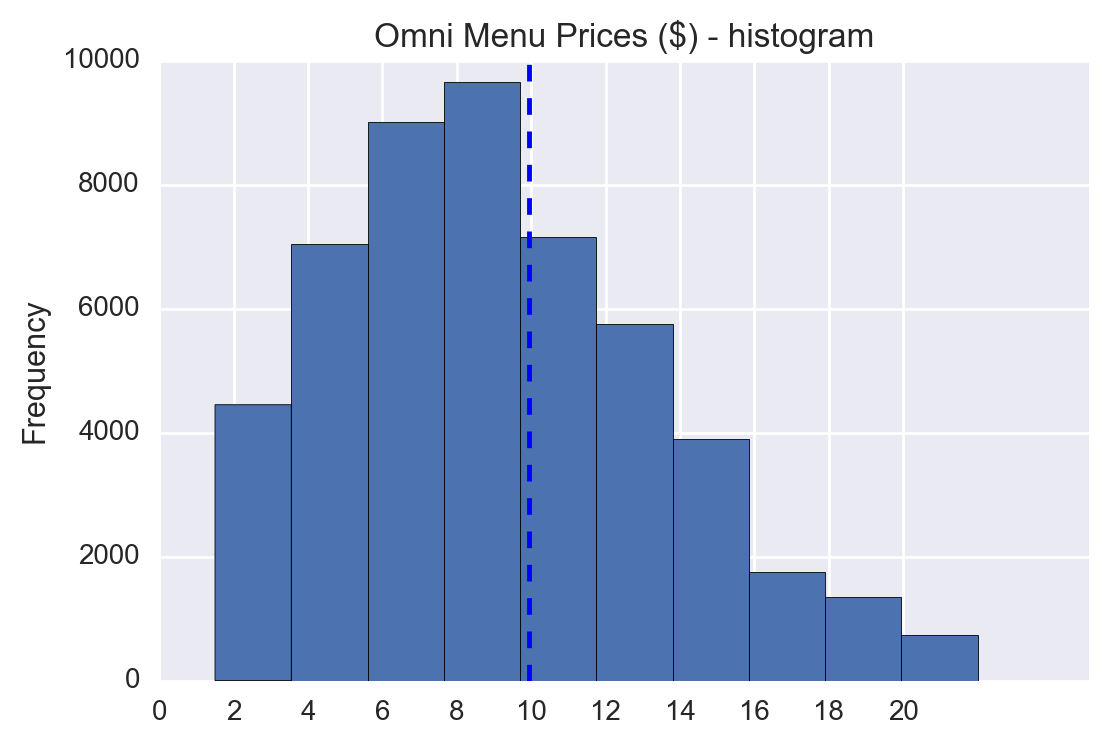

In [134]:
# Histogram of the same data, menu item prices - note how this is only including frequencies > 300
item_price = food[food.groupby('menu_item_price').menu_item_price.transform(len) > 300]
item_price = item_price[item_price.menu_item_price != 'price_not_available']
item_price.menu_item_price.value_counts()

item_price.menu_item_price.sort_values().plot(kind='hist', xticks=range(0,21,2))
plt.axvline(x = has_price['menu_item_price'].median(), linestyle='dashed')
plt.title('Omni Menu Prices ($) - histogram')

Shifting gears again to the vegan subset, we actually see that the most common price drops down to $8.50$, from the previous $12$ price mode inclusive of all venues. I also included another interactive widget to further explore price points.

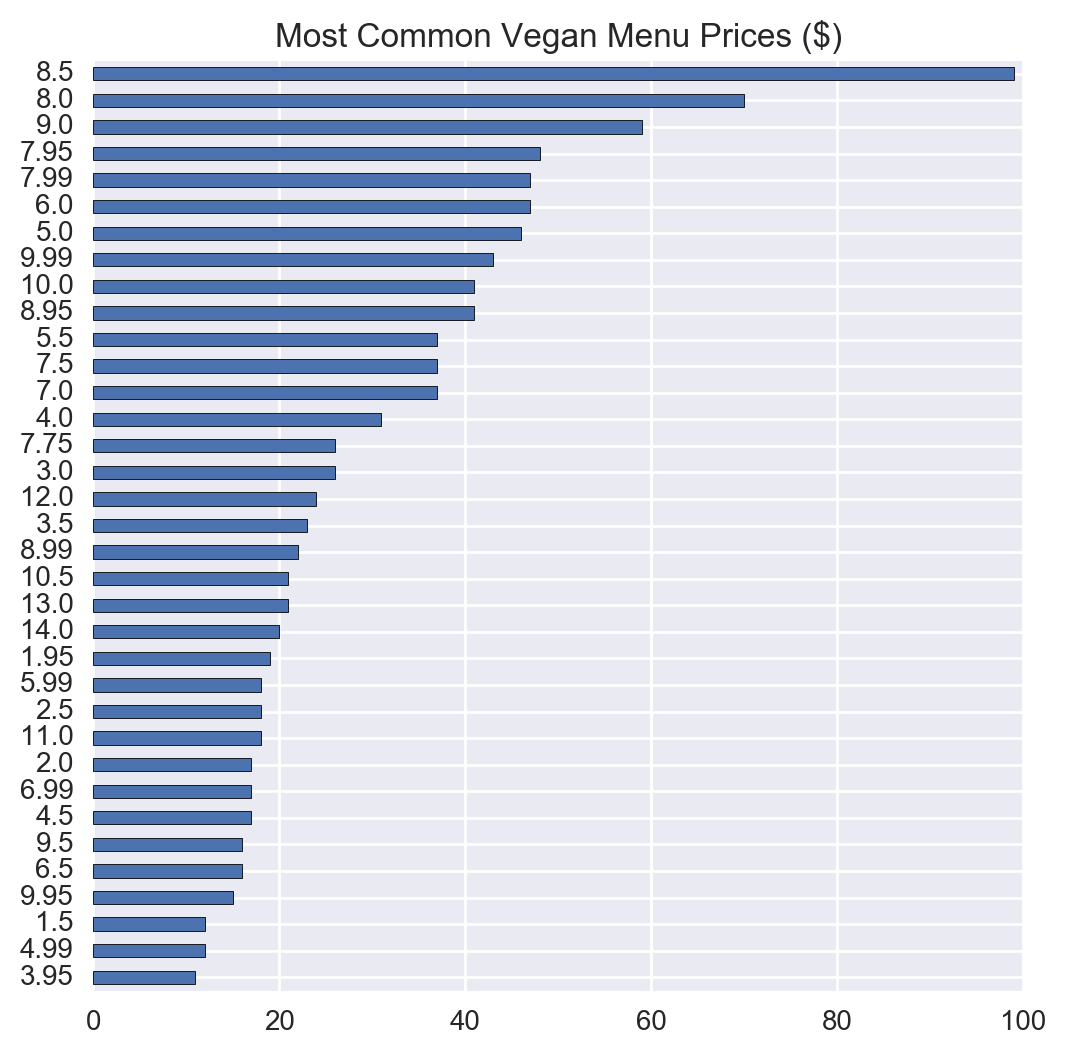

In [135]:
vegan_price = vegan[vegan.groupby('menu_item_price').menu_item_price.transform(len) > 10]
vegan_price = vegan_price[vegan_price.menu_item_price != 'price_not_available']
vegan_price.menu_item_price.value_counts()

plt.figure(figsize=(6,6))
vegan_price['menu_item_price'].value_counts().sort_values().plot(kind='barh')
plt.title('Most Common Vegan Menu Prices ($)')

In [145]:
has_price = vegan[vegan.menu_item_price != 'price_not_available']
# lower_bound = 11.49
# upper_bound = 12.49
def price_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    print "Items in the $%.2f-$%.2f range:" % (lower_bound, upper_bound), common_omni.shape[0]
def percentage_in_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    percents = float(len(common_omni.menu_item_name))/ len(has_price.menu_item_name) * 100.
    print "Approx percentage of items in $%.2f-$%.2f range:" % (lower_bound, upper_bound), round(percents)
def unique_percentage_in_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    print "Approx percentage of unique items in the $%.2f-$%.2f range:" %(lower_bound, upper_bound), \
round(float(len(common_omni.menu_item_name.unique()))/len(has_price.menu_item_name.unique())*100)

In [147]:
lower_bound = widgets.Text(description="Lower Bound:", placeholder="Enter a low price!")
upper_bound = widgets.Text(description="Higher Bound:", placeholder="Enter a high price!")

my_button = widgets.Button(description="This best be good...")

def on_submit(ui):

    item_count = price_range(float(lower_bound.value), float(higher_bound.value))
    percents = percentage_in_range(float(lower_bound.value), float(upper_bound.value))
    percent_counts = unique_percentage_in_range(float(lower_bound.value), float(upper_bound.value))
    return item_count, percents, percent_counts

my_button.on_click(on_submit)

display(lower_bound)
display(upper_bound)
display(my_button)

The histogram of the vegan subset is much more normally distributed, with the median (at exactly $8$) holding inside the mode range of prices.

*Note: I have only included that prices with at least 3 data points in the graph.*

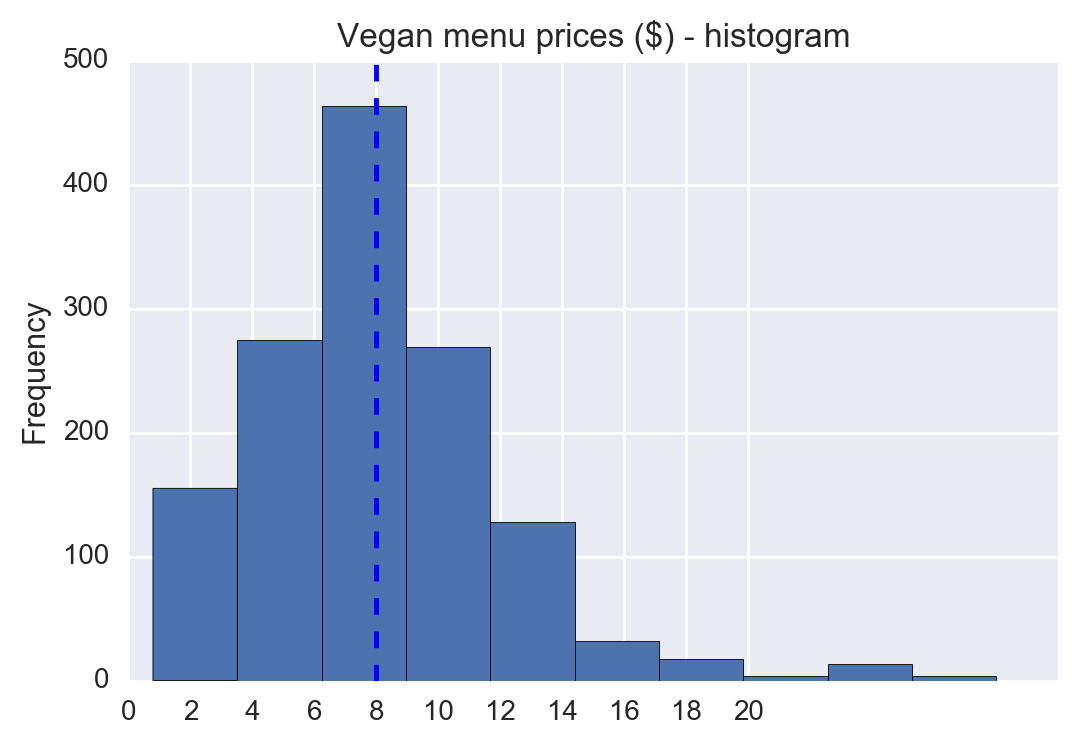

In [143]:
vegan_price = vegan[vegan.groupby('menu_item_price').menu_item_price.transform(len) > 3]
vegan_price = vegan_price[vegan_price.menu_item_price != 'price_not_available']
vegan_price.menu_item_price.value_counts()

vegan_price.menu_item_price.sort_values().plot(kind='hist', xticks=range(0,21,2))
plt.axvline(x = vegan_price.menu_item_price.median(), linestyle='dashed')
plt.title('Vegan menu prices ($) - histogram')

# This histogram result is very interesting, particularly when compared to the Omni

## D. Venue Ratings